[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kesha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



 Sentiment Prediction Accuracy: 1.0000
Confusion Matrix (Sentiment):
[[47  0]
 [ 0 53]]

Classification Report (Sentiment):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        53

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


 Engagement Prediction Accuracy: 0.4000
Confusion Matrix (Engagement):
[[14 20  5]
 [ 6 17  4]
 [10 15  9]]

Classification Report (Engagement):
              precision    recall  f1-score   support

        high       0.47      0.36      0.41        39
         low       0.33      0.63      0.43        27
      medium       0.50      0.26      0.35        34

    accuracy                           0.40       100
   macro avg       0.43      0.42      0.39       100
weighted avg       0.44      0.40      0.39       100


 Sarcasm Prediction 

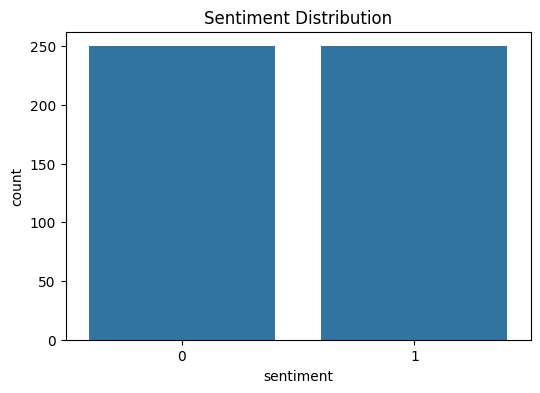

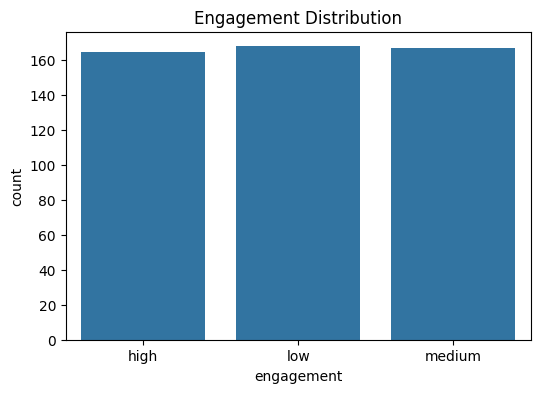

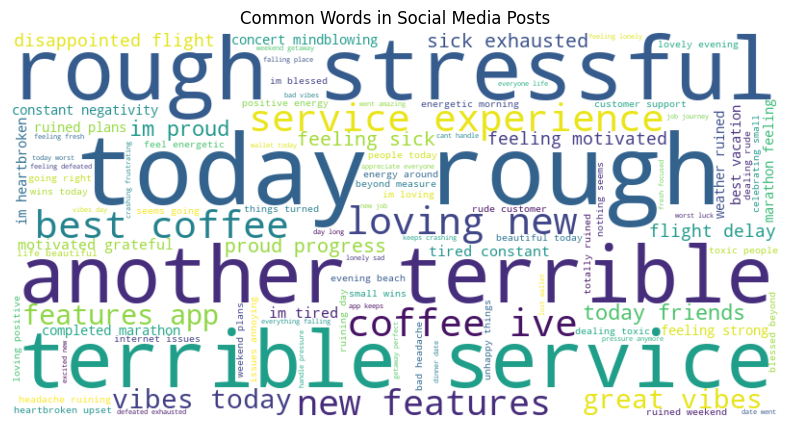

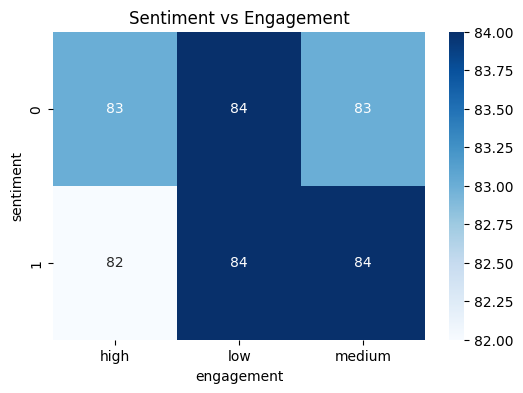


 Post Analysis:
- Sentiment: Negative
- Sarcasm Detected: 0 (Not Sarcastic)
- Recommendation: User less likely to engage. Consider improving the post content.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Load Dataset
df = pd.read_csv('final_dataset_with_sarcasm_and_jokes.csv', encoding='latin-1')
df = df[['text', 'sentiment', 'engagement', 'sarcasm']]


def preprocess(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['text'] = df['text'].apply(preprocess)


X = df[['text', 'sarcasm']]
y_sentiment = df['sentiment']
y_engagement = df['engagement']
y_sarcasm = df['sarcasm']


X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_sentiment, test_size=0.2, random_state=42)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X, y_engagement, test_size=0.2, random_state=42)
X_train_sar, X_test_sar, y_train_sar, y_test_sar = train_test_split(df[['text']], y_sarcasm, test_size=0.2, random_state=42)


column_transformer = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'text'),
        ('sarcasm', FunctionTransformer(lambda x: x.values.reshape(-1, 1)), 'sarcasm')
    ]
)


sentiment_model = Pipeline([
    ('features', column_transformer),
    ('classifier', LogisticRegression())
])
sentiment_model.fit(X_train_s, y_train_s)


engagement_model = Pipeline([
    ('features', column_transformer),
    ('classifier', LogisticRegression())
])
engagement_model.fit(X_train_e, y_train_e)


sarcasm_model = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])
sarcasm_model.fit(X_train_sar['text'], y_train_sar)


def evaluate_model(model, X_test, y_test, label):
    y_pred = model.predict(X_test)
    print(f"\n {label} Prediction Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Confusion Matrix ({label}):")
    print(confusion_matrix(y_test, y_pred))
    print(f"\nClassification Report ({label}):")
    print(classification_report(y_test, y_pred))

evaluate_model(sentiment_model, X_test_s, y_test_s, "Sentiment")
evaluate_model(engagement_model, X_test_e, y_test_e, "Engagement")
evaluate_model(sarcasm_model, X_test_sar['text'], y_test_sar, "Sarcasm")


plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='engagement', data=df)
plt.title('Engagement Distribution')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Common Words in Social Media Posts')
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(pd.crosstab(df['sentiment'], df['engagement']), annot=True, cmap='Blues')
plt.title('Sentiment vs Engagement')
plt.show()


def recommend_action(post_text):
    clean_text = preprocess(post_text)
    sarcasm_score = sarcasm_model.predict([clean_text])[0]
    
    input_df = pd.DataFrame([[clean_text, sarcasm_score]], columns=["text", "sarcasm"])
    sentiment = sentiment_model.predict(input_df)[0]
    engagement = engagement_model.predict(input_df)[0]

    print("\n Post Analysis:")
    print(f"- Sentiment: {'Positive' if sentiment == 1 else 'Negative'}")
    print(f"- Sarcasm Detected: {sarcasm_score} ({'Sarcastic' if sarcasm_score==2 else 'Not Sarcastic'})")
    if engagement == 1:
        print("- Recommendation: User likely to ENGAGE! Suggest posting or boosting it.")
    else:
        print("- Recommendation: User less likely to engage. Consider improving the post content.")


sample_post = "I hate you."
recommend_action(sample_post)
